# Omnigot One-Shot

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import copy
import cv2
from scipy.spatial import distance

In [2]:
import vbranch as vb

In [3]:
save = False
model_id = 4
architecture = 'simple'

## Load Data

In [4]:
train_generator = vb.datasets.omniglot.load_generator('train')
test_generator = vb.datasets.omniglot.load_generator('test')

Images extracted from omniglot/python/images_evaluation.zip


In [7]:
batch = test_generator.next(4, 4, 4, flatten=False)

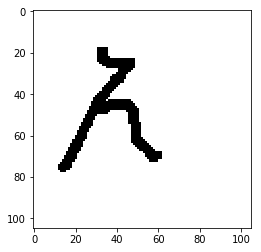

In [8]:
plt.imshow(batch[2, 3, 0].squeeze(), cmap=plt.cm.gray)
plt.show()

## Build Model

In [ ]:
EPOCHS = 90
T_0 = 30
STEPS_PER_EPOCH = 100
model_path = './models/omniglot_' + str(model_id)
A, P, K = 4, 8, 4 # triplet batch specs
output_dim = 128
input_dim = [None, 105, 105, 1]

In [9]:
if not os.path.isdir('./models'):
    os.system('mkdir models')

In [10]:
def batch_gen(A, P, K):
    def func():
        while True:
            batch = train_generator.next(A, P, K)
            batch = batch.astype('float32')
            yield batch
    return func

In [11]:
tf.reset_default_graph()

train_dataset = tf.data.Dataset.from_generator(batch_gen(A, P, K), 'float32', 
                                                 output_shapes=input_dim)

# Dataset for feeding non-triplet batched images from memory
batch_size = tf.placeholder('int64', name='batch_size')
test_dataset = tf.data.Dataset.from_tensor_slices(x).batch(batch_size)

iter_ = tf.data.Iterator.from_structure('float32', input_dim)
train_init_op = iter_.make_initializer(train_dataset)
test_init_op = iter_.make_initializer(test_dataset, name='test_init_op')

inputs = iter_.get_next()

In [12]:
with tf.variable_scope('model_' + str(model_id)):
    if architecture == 'simple':
        model = vb.functional.simple_cnn(inputs, output_dim, 32, 64, 128, 256)
    elif architecture == 'res':
        model = vb.functional.res_cnn(inputs, output_dim, 32, 64, 128, 256)

In [13]:
model.summary()

i   Layer name         Output shape       Parameters            Num param  Inbound            
----------------------------------------------------------------------------------------------
    Input              [None,105,105,1]                                                       
----------------------------------------------------------------------------------------------
0   conv2d_1_1         [None,103,103,32]  [3,3,1,32] [32]       320        IteratorGetNext:0  
----------------------------------------------------------------------------------------------
1   bn_1_1             [None,103,103,32]  [32] [32]             64         conv2d_1_1         
----------------------------------------------------------------------------------------------
2   relu_1_1           [None,103,103,32]                        0          bn_1_1             
----------------------------------------------------------------------------------------------
3   conv2d_1_2         [None,101,101,32]  [3,3,32,

In [14]:
def lr_exp_decay_scheduler(init_lr, t0, t1, decay):
    """NOTE: `episode` starts from 1"""
    def func(episode):
        if episode < t0:
            return init_lr
        lr = init_lr * np.power(decay, (episode - t0) / (t1 - t0))
        return lr
    return func

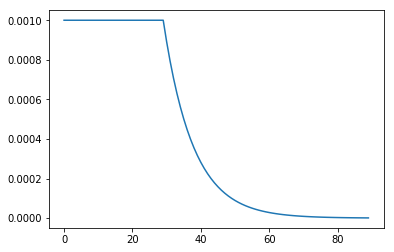

In [15]:
lr_scheduler = lr_exp_decay_scheduler(0.001, T_0, EPOCHS, 0.001)
lr_steps = [lr_scheduler(e + 1) for e in range(EPOCHS)]
plt.plot(lr_steps)
plt.show()

In [16]:
loss = vb.losses.triplet_omniglot(model.output, A, P, K, 'loss')
lr = tf.placeholder('float32', name='lr')
train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

In [17]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(train_init_op)

    for e in range(EPOCHS):
        print("Epoch {}/{}".format(e + 1, EPOCHS))
        progbar = tf.keras.utils.Progbar(STEPS_PER_EPOCH)
        
        learning_rate = lr_scheduler(e + 1)
        for i in range(STEPS_PER_EPOCH):
            _, loss_value = sess.run([train_op, loss], feed_dict={lr:learning_rate})
            progbar.update(i + 1, values=[('loss', loss_value), ('lr', learning_rate)])
    
    if save:
        saver = tf.train.Saver()
        path = os.path.join(model_path, 'ckpt')
        saver.save(sess, path)

Epoch 1/90
100/100 [==============================] - 30s 301ms/step - loss: 203.2345 - lr: 0.0010
Epoch 2/90
100/100 [==============================] - 17s 171ms/step - loss: 34.3832 - lr: 0.0010
Epoch 3/90
100/100 [==============================] - 17s 171ms/step - loss: 30.9500 - lr: 0.0010
Epoch 4/90
100/100 [==============================] - 17s 170ms/step - loss: 28.1805 - lr: 0.0010
Epoch 5/90
100/100 [==============================] - 17s 171ms/step - loss: 26.9174 - lr: 0.0010
Epoch 6/90
100/100 [==============================] - 17s 170ms/step - loss: 25.4925 - lr: 0.0010
Epoch 7/90
100/100 [==============================] - 17s 170ms/step - loss: 24.4774 - lr: 0.0010
Epoch 8/90
100/100 [==============================] - 17s 170ms/step - loss: 23.0067 - lr: 0.0010
Epoch 9/90
100/100 [==============================] - 17s 170ms/step - loss: 20.2327 - lr: 0.0010
Epoch 10/90
100/100 [==============================] - 17s 170ms/step - loss: 18.7231 - lr: 0.0010
Epoch 11/90
100/10

## Model Ensemble

In [18]:
def restore_sess(sess, model_path):
    meta_path = os.path.join(model_path, 'ckpt.meta')
    ckpt = tf.train.get_checkpoint_state(model_path)

    imported_graph = tf.train.import_meta_graph(meta_path)
    imported_graph.restore(sess, ckpt.model_checkpoint_path)

In [19]:
def get_run(n_run):
    all_runs = './omniglot/python/one-shot-classification/all_runs'
    
    if not os.path.isdir(all_runs):
        with zipfile.ZipFile(all_runs + '.zip','r') as zip_ref:
            zip_ref.extractall(all_runs)
    
    run_path = os.path.join(all_runs,'run%02d'%n_run,'class_labels.txt')
    with open(run_path) as f:
        content = f.read().splitlines()

    pairs = [line.split() for line in content]
    test_files  = [pair[0] for pair in pairs]
    train_files = [pair[1] for pair in pairs]

    answers_files = copy.copy(train_files)
    test_files.sort()
    train_files.sort()
    
    def f_load(f):
        path = os.path.join(all_runs, f)
        return cv2.imread(path)[..., 0]

    train_imgs = np.stack([f_load(f) for f in train_files]).\
                        astype('float32')[..., np.newaxis]
    test_imgs  = np.stack([f_load(f) for f in test_files]).\
                        astype('float32')[..., np.newaxis]

    return train_files, test_files, train_imgs, test_imgs, answers_files

In [20]:
def compute_one_shot_acc(test_pred, train_pred, train_files, answers_files):
    n_test = len(test_pred)
    n_train = len(train_pred)
    
    distM = np.zeros((n_test, n_train))
    for i in range(n_test):
        for c in range(n_train):
            distM[i,c] = distance.euclidean(test_pred[i],train_pred[c])
            
    YHAT = np.argmin(distM, axis=1)
    
    # compute the error rate
    correct = 0.0
    for i in range(n_test):
        if train_files[YHAT[i]] == answers_files[i]:
            correct += 1.0
        
    return correct / n_test

In [21]:
total_runs = 20
train_pred_runs = [[] for _ in range(total_runs)]
test_pred_runs = [[] for _ in range(total_runs)]

run_data = [get_run(r+1) for r in range(total_runs)]

num_models = model_id

for i in range(num_models):
    graph = tf.Graph()
    sess = tf.Session(graph=graph)
    
    with sess.as_default(), graph.as_default():
        restore_sess(sess, './models/omniglot_' + str(i + 1))
        
        for r in range(total_runs):
            train_files,test_files,train_imgs,test_imgs,answers_files = run_data[r]
            
            feed_dict = {'x:0':train_imgs, 'batch_size:0':len(train_imgs)}
            sess.run('test_init_op', feed_dict=feed_dict)
            train_pred_runs[r].append(sess.run('model_%d'%(i+1)+'/'+'output:0'))
    
            feed_dict = {'x:0':test_imgs, 'batch_size:0':len(test_imgs)}
            sess.run('test_init_op', feed_dict=feed_dict)
            test_pred_runs[r].append(sess.run('model_%d'%(i+1)+'/'+'output:0'))

INFO:tensorflow:Restoring parameters from ./models/omniglot_1/ckpt
INFO:tensorflow:Restoring parameters from ./models/omniglot_2/ckpt
INFO:tensorflow:Restoring parameters from ./models/omniglot_3/ckpt
INFO:tensorflow:Restoring parameters from ./models/omniglot_4/ckpt


### Average Embedding

In [22]:
mean_acc_runs = []
for r in range(total_runs):
    test_embed = np.mean(test_pred_runs[r], axis=0)
    train_embed = np.mean(train_pred_runs[r], axis=0)
    train_files = run_data[r][0]
    answers_files = run_data[r][-1]
    
    acc = compute_one_shot_acc(test_embed, train_embed,train_files, answers_files)
    mean_acc_runs.append(acc)

In [23]:
print(mean_acc_runs)
print(np.mean(mean_acc_runs))

[0.8, 0.7, 0.95, 0.8, 0.85, 0.95, 0.75, 0.65, 0.65, 0.75, 1.0, 0.7, 0.65, 0.9, 0.95, 1.0, 0.8, 0.95, 0.7, 0.75]
0.8125


### Concatenate Embedding

In [24]:
concat_acc_runs = []
for r in range(total_runs):
    test_embed = np.concatenate(test_pred_runs[r], axis=-1)
    train_embed = np.concatenate(train_pred_runs[r], axis=-1)
    train_files = run_data[r][0]
    answers_files = run_data[r][-1]
    
    acc = compute_one_shot_acc(test_embed, train_embed,train_files, answers_files)
    concat_acc_runs.append(acc)

In [25]:
print(concat_acc_runs)
print(np.mean(concat_acc_runs))

[0.9, 0.8, 0.95, 0.85, 0.95, 0.9, 0.8, 0.65, 0.7, 0.85, 1.0, 0.85, 0.7, 0.9, 0.95, 1.0, 0.8, 1.0, 0.85, 0.8]
0.8600000000000001
